In [1]:
from datetime import datetime

import pandas as pd
import numpy as np
import altair as alt
import iso3166

pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 200)

# Uncomment this and cells with altair charts
# Disabled by default to keep notebook size small
# alt.data_transformers.disable_max_rows()

In [2]:
AUSGANGS_MAPPING = {
    'A': 'A: Klage abgewiesen',
    'B': 'B: Berufung abgelehnt',
    'C': 'C: Verfahren ohne Visum eingestellt, wahrscheinlich Visum später',
    'D': 'D: Verfahren eingestellt bzw. Vergleich mit Visum',
    'E': 'E: Teilweise Aufhebung',
    'F': 'F: Verpflichtung zur Visumserteilung',
    'G': 'G: Erledigung mit Visumserteilung',
    'H': 'H: Berufungsrücknahme durch AA',
    'I': 'I: Aufhebung',
    'J': 'J: Verfahreneinstellung ohne Visum',
    'K': 'K: Beschwerde von AA wird stattgegeben'
}

## Daten laden und säubern

In [3]:
filename = 'Asyl-Streitverfahren_STATISTIK_3. Q 2020.csv'
df = pd.read_csv(filename, encoding='ISO8859-1', delimiter=';')
df[df['Statistk vom'].str.contains('#').fillna(False)]

,LFD_NR,VG AZ,EingangsDatum,Lnderkrzel,Vertretung,Grund,_Zusatz,Statistik,Statistk vom,Gz_OVG,Ausgang OVG,Datum OVG_,Gz PKH Beschwerde,Ausgang PKH,Datum PKH_,Gz_BVerwG,Ausgang BVerwG,Datum BVerwG_
4050,29455,VG 36 V 45.08,31-Jul-08,TGO,NaN,FZ-E,NaN,D,##############################################...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
date_mapping = {
    'Mär': 'Mar',
    'Mai': 'May',
    'Okt': 'Oct',
    'Dez': 'Dec'
}


def make_date(x):
    if pd.isnull(x):
        return x
    
    x = x.replace('Mrz', 'Mär')
    for k, v in date_mapping.items():
      x = x.replace(k, v)
    try:
        return datetime.strptime(x, "%d-%b-%y")
    except ValueError:
        print(x)
    return np.nan

date_cols = ['EingangsDatum', 'Datum PKH_', 'Statistk vom', 'Datum OVG_', 'Datum BVerwG_']

df = pd.read_csv(filename, encoding='ISO8859-15', delimiter=';', parse_dates=date_cols,
                date_parser=make_date)
df = df.rename(columns={
    'Lnderkrzel': 'country',
})
df.head()

###############################################################################################################################################################################################################################################################
###############################################################################################################################################################################################################################################################
00-Jan-00
00-Jan-00


,LFD_NR,VG AZ,EingangsDatum,country,Vertretung,Grund,_Zusatz,Statistik,Statistk vom,Gz_OVG,Ausgang OVG,Datum OVG_,Gz PKH Beschwerde,Ausgang PKH,Datum PKH_,Gz_BVerwG,Ausgang BVerwG,Datum BVerwG_
0,25370,VG 29 A 20.07,2007-01-03,UKR,NaN,?,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT
1,25371,VG 25 V 82.06> VG 02 V 44.07,2007-01-03,PAK,NaN,?,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT
2,25372,VG 18 V 77.06,2007-01-03,TUR,NaN,?,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT
3,25373,VG 18 V 78.06,2007-01-03,SRB,NaN,?,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT
4,25374,VG 18 V 79.06,2007-01-03,SRB,NaN,?,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT


In [5]:
EXCLUDES = []

In [6]:
EXCLUDES.append(((df['EingangsDatum'].dt.year < 2007), "Jahr vor 2007 bei Eingangsdatum"))
EXCLUDES.append(((df['Datum PKH_'].dt.year < 2007), "Jahr vor 2007 bei PKH"))
EXCLUDES.append(((df['Statistk vom'].dt.date > datetime.now().date()), "Statistik Datum nach heute"))

In [7]:
len(df)

31176

In [8]:
COUNTRIES = list(iso3166.countries_by_alpha3.keys()) + ['KOS', 'SCG', ]
COUNTRY_NAMES = {k: v.name for k, v in iso3166.countries_by_alpha3.items()}
COUNTRY_NAMES['KOS'] = 'Kosovo'
COUNTRY_NAMES['SCG'] = 'Serbien und Montenegro'

In [9]:
df['country'] = df['country'].str.upper().str.strip()
df['country'] = df['country'].replace('?', np.nan)
df['country_name'] = df['country'].map(COUNTRY_NAMES)
df['country_name'].value_counts().head(20)

Turkey                       4171
Syrian Arab Republic         2314
Kosovo                       2045
Pakistan                     1718
Morocco                      1367
India                        1222
Viet Nam                     1149
Ukraine                      1026
Serbia                       1006
Iran, Islamic Republic of     939
Iraq                          832
Nigeria                       776
Russian Federation            712
Ghana                         640
Afghanistan                   637
Eritrea                       635
Tunisia                       546
North Macedonia               528
Philippines                   512
Bosnia and Herzegovina        510
Name: country_name, dtype: int64

In [10]:
# Unbekannte Länderbezeichnungen
len(df[df['country'].notnull() & df['country'].apply(lambda x: x not in COUNTRIES)])

237

In [11]:
df[df['country'].str.startswith('X').fillna(False)]['country'].value_counts()

XXA    138
XYZ     61
XXX     21
Name: country, dtype: int64

In [12]:
EXCLUDES.append(((df['country'].isnull() | df['country'].apply(lambda x: x not in COUNTRIES)), 'Country unknown'))

In [13]:
df['Vertretung'].value_counts(dropna=False).head(20)

NaN            9443
Ankara         1871
Beirut         1626
Pristina       1436
Islamabad      1227
Rabat           975
Istanbul        826
New Delhi       814
Teheran         716
Addis Abeba     623
Lagos           564
Hanoi           551
Nairobi         543
Kiew            492
Erbil           465
Manila          413
Kairo           411
Tunis           398
Belgrad         383
Izmir           370
Name: Vertretung, dtype: int64

In [14]:
VERFAHRENSAUSGANG = list('ABCDEFGHIJK')
KEINE_KOSTEN_AA = list('ABCDJ')

def clean_statistik(val):
    if pd.isnull(val):
        return val
    if ';' in val:
        # Take last value if ; is present
        val = val.rsplit(';', 1)[1]
    val = val.replace('1/2', '').replace('0', '').strip()
    if val not in VERFAHRENSAUSGANG:
        return np.nan
    return val

def clean_statistik_kosten(val):
    if pd.isnull(val):
        return val
    if ';' in val:
        val = val.rsplit(';', 1)[1]
    val = val.replace(' ', '')
    if '1/2' in val:
        return 0.5
    if '0' in val:
        return 0
    if val in KEINE_KOSTEN_AA:
        return 0
    return 1

def first_valid_value(row, cols):
    index = row[cols].first_valid_index()
    if index is None:
        return np.nan
    return row[index]

def determine_verfahrensausgang(row):
    '''
    Wenn Verfahrensausgang B oder H ist, gilt der Ausgang der Vorinstanz
    '''
    instances = ['verfahrensausgang_bverwg', 'verfahrensausgang_ovg', 'verfahrensausgang_vg']
    for instance in instances:
        if pd.isnull(row[instance]):
            continue
        if row[instance] in ('B', 'H'):
            continue
        return row[instance]
    return row[instance]

df['verfahrensausgang_vg'] = df['Statistik'].apply(clean_statistik)
df['verfahrensausgang_ovg'] = df['Ausgang OVG'].apply(clean_statistik)
df['verfahrensausgang_bverwg'] = df['Ausgang BVerwG'].apply(clean_statistik)
df['highest_instance'] = df.apply(lambda row: 'bverwg' if pd.notnull(row['verfahrensausgang_bverwg']) else
                                                                     'ovg' if pd.notnull(row['verfahrensausgang_ovg']) else 'vg', 1)
df['kosten_aa_vg'] = df['Statistik'].apply(clean_statistik_kosten)
df['kosten_aa_ovg'] = df['Ausgang OVG'].apply(clean_statistik_kosten)
df['kosten_aa_bverwg'] = df['Ausgang BVerwG'].apply(clean_statistik_kosten)
df['verfahrensausgang'] = df.apply(lambda row: determine_verfahrensausgang(row), 1)
# Kosten richten sich nach der nächsten Instanz
df['kosten_aa'] = df.apply(lambda row: first_valid_value(row, ['kosten_aa_bverwg', 'kosten_aa_ovg', 'kosten_aa_vg']), 1)
df['verfahrensausgang_datum'] = df.apply(lambda row: first_valid_value(row, ['Datum BVerwG_', 'Datum OVG_', 'Statistk vom']), 1)

df['duration'] = (df['verfahrensausgang_datum'] - df['EingangsDatum']).dt.days
df['verfahrensausgang_previously_f'] = df.apply(lambda row: row[['verfahrensausgang_bverwg', 'verfahrensausgang_ovg', 'verfahrensausgang_vg']].str.contains('F').any(), 1)

In [15]:
len(df[(df['verfahrensausgang_vg'] == "F")])

483

In [16]:
print(sum(df['duration'] < 0))
EXCLUDES.append(((df['duration'] < 0), 'Letztes Verfahrensdatum vor Eingangsdatum'))

236


In [17]:
df['Ausgang PKH'].value_counts()

M        366
A         60
L         51
?         48
C         22
B          6
J0         2
D          2
N          2
J 0        1
A; M       1
B; M       1
G0         1
K          1
G 1/2      1
Name: Ausgang PKH, dtype: int64

Enthält der Verfahrensausgang ein Semikolon (;), so gibt es unterschiedliche Verfahrensausgänge für die betroffenen Personen in einem Fall. Da diese sich nicht sinnvoll unterscheiden lassen und es sich um nur wenige Fälle handelt, werden diese von der Analyse ausgeschlossen.

In [18]:
sum(df['Statistik'].str.contains(';').fillna(False))

68

In [19]:
EXCLUDES.append(((df['Statistik'].str.contains(';').fillna(False)), 'Statistik contains ;'))
EXCLUDES.append(((df['Ausgang OVG'].str.contains(';').fillna(False)), 'Ausgang OVG contains ;'))
EXCLUDES.append(((df['Ausgang BVerwG'].str.contains(';').fillna(False)), 'Ausgang BVerwG contains ;'))

In [20]:
df['Ausgang PKH'].value_counts()

M        366
A         60
L         51
?         48
C         22
B          6
J0         2
D          2
N          2
J 0        1
A; M       1
B; M       1
G0         1
K          1
G 1/2      1
Name: Ausgang PKH, dtype: int64

In [21]:
df['Grund'] = df['Grund'].str.upper().str.strip()
df['familie'] = df['Grund'].str.startswith('FZ').fillna(False)
df['Grund'].value_counts()

FZ-E      11123
BES        8218
FZ-K       3445
FZ-F       2082
FZ-E/K     1982
EWT        1610
STU         979
?           558
SON         502
SPR         363
WDK         205
KON          62
NZ-G         34
BVF          10
ZZZ           1
Name: Grund, dtype: int64

Wir betrachten nur den Familiennachzug.

In [22]:
EXCLUDES.append(((~df['familie']), 'Only FZ'))
df['familie'].describe()

count     31176
unique        2
top        True
freq      18632
Name: familie, dtype: object

In [23]:
df['_Zusatz'].value_counts(dropna=False)

NaN                     21223
SE                       2624
LU                       1635
õ 36 II                   608
õ 26 II BV                305
                        ...  
õ 36 a; Ehewi               1
Dt., Unt., AssR             1
UT, õ 29 Ii, 2 Nr. 2        1
LU, 29 III                  1
C2                          1
Name: _Zusatz, Length: 751, dtype: int64

### Ausfiltern des Datensatzes

In [24]:
print('Datensätze vorher: ', len(df))
old_len = len(df)
for cond, descr in EXCLUDES:
    print('- ', descr)
    df = df.drop(df[cond].index)
print('Datensätze nachher: ', len(df), old_len - len(df), 'weniger')

Datensätze vorher:  31176
-  Jahr vor 2007 bei Eingangsdatum
-  Jahr vor 2007 bei PKH
-  Statistik Datum nach heute
-  Country unknown
-  Letztes Verfahrensdatum vor Eingangsdatum
-  Statistik contains ;
-  Ausgang OVG contains ;
-  Ausgang BVerwG contains ;
-  Only FZ
Datensätze nachher:  18286 12890 weniger


<ipython-input-24-368d7f795ff8>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.drop(df[cond].index)


# Analyse



In [25]:
df['EingangsDatum'].describe(datetime_is_numeric=True)

count                            18286
mean     2013-10-28 17:01:22.292464128
min                2007-01-10 00:00:00
25%                2009-10-02 00:00:00
50%                2013-07-08 00:00:00
75%                2018-02-07 18:00:00
max                2020-10-08 00:00:00
Name: EingangsDatum, dtype: object

In [26]:
df['Statistk vom'].describe(datetime_is_numeric=True)

count                            15605
mean     2013-09-16 23:42:44.639538432
min                2007-01-16 00:00:00
25%                2010-03-02 00:00:00
50%                2013-02-25 00:00:00
75%                2017-05-12 00:00:00
max                2020-10-05 00:00:00
Name: Statistk vom, dtype: object

### Grobe Übersicht über die enthaltenen Datumsangaben

In [27]:
def make_date_df(df, id_vars=None):
    if id_vars is None:
        id_vars = []
    return df.melt(
        id_vars=['LFD_NR', 'VG AZ', 'country', 'Vertretung', 'Grund', '_Zusatz'] + id_vars,
        value_vars=['EingangsDatum', 'Statistk vom', 'Datum OVG_', 'Datum PKH_', 'Datum BVerwG_'],
        var_name='kind', value_name='date'
    )

In [28]:
date_df = make_date_df(df)

grouped_df = date_df.groupby(['date', 'kind'])['VG AZ'].count().unstack().resample('1M').sum().reset_index().melt(
    id_vars='date',
    value_name='count'
)
grouped_df.head()

,date,kind,count
0,2007-01-31,Datum BVerwG_,0.0
1,2007-02-28,Datum BVerwG_,0.0
2,2007-03-31,Datum BVerwG_,0.0
3,2007-04-30,Datum BVerwG_,0.0
4,2007-05-31,Datum BVerwG_,0.0


In [29]:
# alt.Chart(grouped_df).mark_bar().encode(
#     x='date',
#     y='count',
#     color='kind'
# ).properties(
#     width=1800,
#     height=400
# )

# Recherchefragen

## Wie hoch ist die Vergleichsquote?

Im folgenden wird 'Vergleich' für die Verfahrensausgänge D und G (Einstellung und Erledigung) verwendet.
Eine Visa-Erteilung wird bei Verfahrensausgängen D, G und F angenommen.

Auch Kategorie C ist laut Aussage des Sachbearbeiters oft Vergleich ("60 - 80% der Fälle"). Werden Visumsbedingungen nach Klagerücknahme erfüllt, wird das Visum genehmigt. Nur ~ein Drittel seien eine glatte Rücknahme.

Wir berechnen daher die Vergleiche D+G und einen Bereich für die Visaerteilung bei Verfahrensausgang C.

In [30]:
VISA_ALLE = list('DGF')
VISA_VERGLEICH = list('DG')
VISA_C_RANGE = [0.6, 0.8]

def calculate_vergleichsquote(df, year=None):

    visa_erteilt_c = (df['verfahrensausgang'] == 'C').sum()

    total_count = len(df)
    visa_erteilt = df['verfahrensausgang'].isin(VISA_ALLE).sum()
    total_count = len(df)
    visa_erteilt_low = visa_erteilt + VISA_C_RANGE[0] * visa_erteilt_c
    visa_erteilt_high = visa_erteilt + VISA_C_RANGE[1] * visa_erteilt_c

    visa_vergleich = df['verfahrensausgang'].isin(VISA_VERGLEICH).sum()
    visa_vergleich_low = visa_vergleich + VISA_C_RANGE[0] * visa_erteilt_c
    visa_vergleich_high = visa_vergleich + VISA_C_RANGE[1] * visa_erteilt_c


    return pd.Series({
        'year': year,
        'total': total_count,
        'erteilt': visa_erteilt,
        'erteilt_high': visa_erteilt_high,
        'erteilt_low': visa_erteilt_low,
        'erteilt_prozent': visa_erteilt / total_count * 100,
        'erteilt_prozent_high': visa_erteilt_high / total_count * 100,
        'erteilt_prozent_low': visa_erteilt_low / total_count * 100,
        'vergleich': visa_vergleich,
        'vergleich_high': visa_vergleich_high,
        'vergleich_low': visa_vergleich_low,
        'vergleichsquote': visa_vergleich / visa_erteilt * 100,
        'vergleichsquote_high': visa_vergleich_high / visa_erteilt_high * 100,
        'vergleichsquote_low': visa_vergleich_low / visa_erteilt_low * 100,
    })

df['visa_erteilt'] = df['verfahrensausgang'].isin(VISA_ALLE)
df['visa_mit_vergleich'] = df['verfahrensausgang'].isin(VISA_VERGLEICH)
df['visa_ohne_vergleich'] = df['visa_erteilt'] & ~df['visa_mit_vergleich']
print(calculate_vergleichsquote(df))

year                             NaN
total                   18286.000000
erteilt                  5642.000000
erteilt_high             9749.200000
erteilt_low              8722.400000
erteilt_prozent            30.854205
erteilt_prozent_high       53.315104
erteilt_prozent_low        47.699880
vergleich                5347.000000
vergleich_high           9454.200000
vergleich_low            8427.400000
vergleichsquote            94.771358
vergleichsquote_high       96.974111
vergleichsquote_low        96.617903
dtype: float64


In [31]:
df_final = df[df['verfahrensausgang'].notnull()]

In [32]:
df['visa_erteilt'].sum()

5642

In [33]:
df['visa_mit_vergleich'].sum()

5347

In [34]:
df['visa_ohne_vergleich'].sum()

295

Vergleichsquote über die Jahre

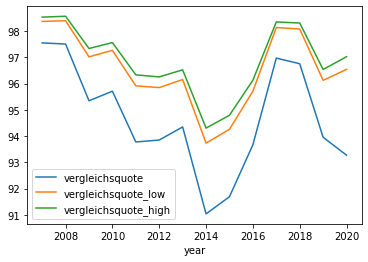

In [35]:
grouped = df.groupby(df['verfahrensausgang_datum'].dt.year)
quota_by_year = pd.DataFrame(calculate_vergleichsquote(rows, year=group) for group, rows in grouped)
quota_by_year.set_index('year')[['vergleichsquote', 'vergleichsquote_low', 'vergleichsquote_high']].plot()

In [36]:
print('Anzahl der Visa-Erteilung an allen Verfahren', df['visa_erteilt'].sum(),' = ', df['visa_erteilt'].sum() / df['verfahrensausgang'].notnull().sum() * 100, '%')

Anzahl der Visa-Erteilung an allen Verfahren 5642  =  36.044208777870054 %


In [37]:
len(df)

18286

### Verfahrensausgänge über die Zeit

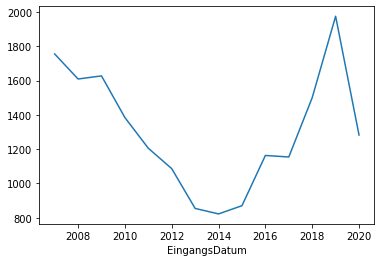

In [38]:
df.groupby(df['EingangsDatum'].dt.year).size().plot()

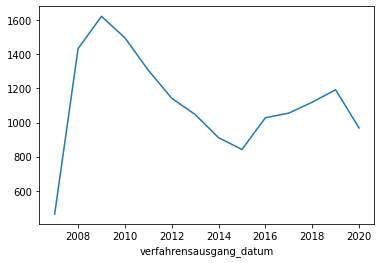

In [39]:
df.groupby(df['verfahrensausgang_datum'].dt.year).size().plot()

In [40]:
df.query('visa_erteilt and visa_mit_vergleich').groupby(df['verfahrensausgang_datum'].dt.year).size()

verfahrensausgang_datum
2007.0    199
2008.0    547
2009.0    553
2010.0    513
2011.0    452
2012.0    412
2013.0    384
2014.0    325
2015.0    309
2016.0    355
2017.0    320
2018.0    328
2019.0    373
2020.0    208
dtype: int64

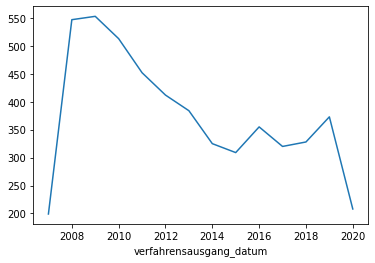

In [41]:
df.query('visa_erteilt and visa_mit_vergleich').groupby(df['verfahrensausgang_datum'].dt.year).size().plot()

In [42]:
df.query('kosten_aa == 0.0 and visa_erteilt')['verfahrensausgang'].value_counts()

D    4262
G     395
F      51
Name: verfahrensausgang, dtype: int64

In [43]:
print('Verfahrensausgänge in Prozent:')
df['verfahrensausgang'].value_counts() / len(df['verfahrensausgang']) * 100

Verfahrensausgänge in Prozent:


C    28.076124
D    23.832440
A    21.431696
G     5.408509
J     4.845237
F     1.613256
E     0.169529
K     0.142185
I     0.043749
B     0.038281
Name: verfahrensausgang, dtype: float64

In [44]:
df['verfahrensausgang'].value_counts(dropna=False)

C      5134
D      4358
A      3919
NaN    2633
G       989
J       886
F       295
E        31
K        26
I         8
B         7
Name: verfahrensausgang, dtype: int64

In [45]:
print('Median-Verfahrensdauer nach Ausgang in Tagen:')
df.groupby('verfahrensausgang')['duration'].median()

Median-Verfahrensdauer nach Ausgang in Tagen:


verfahrensausgang
A     338.0
B     163.0
C     246.0
D     260.0
E     314.0
F     370.0
G     160.0
I    1265.5
J     271.0
K     756.5
Name: duration, dtype: float64

In [46]:
dauer_mit_vergleich = df.query('visa_mit_vergleich')['duration'].mean()

### Unterschied in der Verfahrensdauer (Datum Eingang bis Datum Statistik)

Dauern erfolgreiche Visa-Verfahren ohne Vergleich länger? Der Schnitt sagt ja, aber die Verteilung ist nicht so offensichtlich.

In [47]:
print('Dauer der Verfahren mit Visa im Schnitt:', round(df.query('visa_erteilt')['duration'].mean()), 'Tage')

Dauer der Verfahren mit Visa im Schnitt: 299.0 Tage


In [48]:
print('Dauer der Verfahren mit Vergleich im Schnitt:', round(df.query('visa_mit_vergleich')['duration'].mean()), 'Tage')

Dauer der Verfahren mit Vergleich im Schnitt: 290.0 Tage


In [49]:
print('Dauer der Verfahren ohne Vergleich im Schnitt:', round(df.query('visa_ohne_vergleich')['duration'].mean()), 'Tage')

Dauer der Verfahren ohne Vergleich im Schnitt: 456.0 Tage


Ein Histogram der Verfahrensdauer für Vergleich und ohne. Da springt der Unterschied nicht ins Auge.

In [50]:
# (
#     alt.Chart(df.query('visa_erteilt and highest_instance == "vg"'))
#     .mark_area(
#         opacity=0.3,
#         interpolate='step'
#     ).encode(
#         alt.X('duration:Q', bin=alt.Bin(maxbins=50)),
#         alt.Y('count()', stack=None),
#         alt.Color('visa_mit_vergleich'),
#         column='year(EingangsDatum)'
#     )
#     .properties(
#         title="Verfahrensdauer in Tagen bei VG-Verfahren, in denen ein Visum erteilt wurde, nach Vergleich und Eingangsdatumsjahr"
#     )
# )

Normalisiert nach Kategorie:

In [51]:
# (
#     alt.Chart(df.query('visa_erteilt'))
#     .transform_joinaggregate(
#         total='count(*)',
#         groupby=['visa_mit_vergleich']
#     ).transform_calculate(
#         pct='1 / datum.total'
#     )
#     .mark_area(
#         opacity=0.3,
#         interpolate='step'
#     ).encode(
#         alt.X('duration:Q', bin=alt.Bin(maxbins=50)),
# #         alt.Y('sum(duration)', stack="normalize"),
#         alt.Y('sum(pct):Q', axis=alt.Axis(format='%'), stack=None),
#         alt.Color('visa_mit_vergleich'),
#         column='year(EingangsDatum)'
#     )
#     .properties(
#         title="Verfahrensdauer in Tagen bei VG-Verfahren, in denen ein Visum erteilt wurde, nach Vergleich und Eingangsdatumsjahr, normalisiert"
#     )
# )

In [52]:
df.query('visa_ohne_vergleich')['duration'].describe()

count     293.000000
mean      455.802048
std       352.986740
min         2.000000
25%       241.000000
50%       370.000000
75%       554.000000
max      1995.000000
Name: duration, dtype: float64

In [53]:
df.query('visa_mit_vergleich')['duration'].describe()

count    5278.000000
mean      290.276809
std       223.454014
min         1.000000
25%       141.000000
50%       245.000000
75%       374.000000
max      2870.000000
Name: duration, dtype: float64

## Vergleichsquote in Prozent über die Jahre

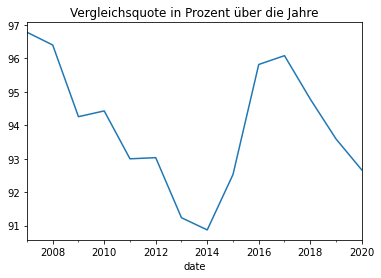

In [54]:
date_df = make_date_df(df.query('visa_erteilt'), ['visa_mit_vergleich'])
time_frame = '1A'
vmv_df = (
    date_df.groupby(['date'])['visa_mit_vergleich'].sum().resample(time_frame).sum() /
    date_df.groupby(['date'])['visa_mit_vergleich'].count().resample(time_frame).sum()
) * 100

vmv_df.plot(title='Vergleichsquote in Prozent über die Jahre')

### Vergleichsquote nach Ländern mit Anzahl der Fälle

In [55]:
df.query('visa_erteilt').pivot_table(
    index=['country'],
    values='visa_mit_vergleich',
    aggfunc=[np.mean, len]
).sort_values(('mean', 'visa_mit_vergleich'), ascending=False).head(20)

,mean,len
,visa_mit_vergleich,visa_mit_vergleich
country,,
LBY,1.0,4
HRV,1.0,10
JAM,1.0,1
JOR,1.0,27
KGZ,1.0,5
KWT,1.0,1
MEX,1.0,1
MLI,1.0,2


## Kosten bei Visa-Erteilung

In [56]:
no_cost = (df_final.query('visa_erteilt')['kosten_aa'] == 0).mean() * 100
print(f'Der Staat trägt bei Visa-Erteilung in {no_cost}% der Verfahren keine Kosten.')

Der Staat trägt bei Visa-Erteilung in 83.44558667139313% der Verfahren keine Kosten.


In [57]:
some_cost = (df_final.query('visa_erteilt')['kosten_aa'] == 0.5).mean() * 100
print(f'Der Staat trägt bei Visa-Erteilung in {some_cost}% der Verfahren die Hälfte der Kosten.')

Der Staat trägt bei Visa-Erteilung in 5.175469691598724% der Verfahren die Hälfte der Kosten.


In [58]:
some_cost = (df_final.query('visa_erteilt')['kosten_aa'] == 1.0).mean() * 100
print(f'Der Staat trägt bei Visa-Erteilung in {some_cost}% der Verfahren die gesamten Kosten.')

Der Staat trägt bei Visa-Erteilung in 11.378943637008152% der Verfahren die gesamten Kosten.


In [59]:
no_cost = (df_final.query('~visa_erteilt')['kosten_aa'] == 0).mean() * 100
print(f'Der Staat trägt bei keiner Visa-Erteilung in {no_cost}% der Verfahren keine Kosten.')

Der Staat trägt bei keiner Visa-Erteilung in 97.06323044650884% der Verfahren keine Kosten.


In [60]:
some_cost = (df_final.query('~visa_erteilt')['kosten_aa'] == 0.5).mean() * 100
print(f'Der Staat trägt bei keiner Visa-Erteilung in {some_cost}% der Verfahren die Hälfte der Kosten.')

Der Staat trägt bei keiner Visa-Erteilung in 0.8790330636300071% der Verfahren die Hälfte der Kosten.


In [61]:
some_cost = (df_final.query('~visa_erteilt')['kosten_aa'] == 1.0).mean() * 100
print(f'Der Staat trägt bei keiner Visa-Erteilung in {some_cost}% der Verfahren die gesamten Kosten.')

Der Staat trägt bei keiner Visa-Erteilung in 2.0577364898611528% der Verfahren die gesamten Kosten.


In [62]:
(df_final.query('visa_mit_vergleich')['kosten_aa'] != 0.0).sum()

690

In [63]:
df.query('verfahrensausgang == "C"')['kosten_aa'].value_counts()

0.0    5075
1.0      39
0.5      20
Name: kosten_aa, dtype: int64

## Unterschiedliche Verfahrensausgänge über die Zeit

In [64]:
# year_outcomes = (
#     df.groupby(['verfahrensausgang_datum', 'verfahrensausgang'])['VG AZ'].count()
#         .unstack().resample('1A').sum()
#         .stack().reset_index().rename(columns={0: 'count'})
# )
# year_outcomes['label'] = year_outcomes['verfahrensausgang'].map(AUSGANGS_MAPPING)

# alt.Chart(year_outcomes).mark_line().encode(
#     x='verfahrensausgang_datum',
#     y='count',
#     column='label'
# )

In [65]:
last_date = df.apply(lambda x: x[['Statistk vom',  'Datum BVerwG_', 'Datum PKH_', 'Datum OVG_']].dropna().max(), 1)
last_date.describe()

<ipython-input-65-94d99211bc15>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  last_date.describe()


count                   15643
unique                   3386
top       2009-02-11 00:00:00
freq                       20
first     2007-01-16 00:00:00
last      2020-10-05 00:00:00
dtype: object

## Wenn Visa erteilt wurde, was waren die Klagegründe ohne und mit Vergleich

In [66]:
df_erteilt_grund = df[df['visa_erteilt']].groupby(['Grund', 'visa_mit_vergleich']).size().unstack()
df_erteilt_grund['sum'] = df_erteilt_grund.sum(axis=1)
df_erteilt_grund['percent'] = df_erteilt_grund.apply(lambda x: x[True] / x['sum'] * 100, axis=1)
df_erteilt_grund

visa_mit_vergleich,False,True,sum,percent
Grund,,,,
FZ-E,180,3594,3774,95.230525
FZ-E/K,20,594,614,96.742671
FZ-F,40,296,336,88.095238
FZ-K,55,863,918,94.008715


## Wie viele Verfahren pro Jahr?

Plot nach Eingangsdatum

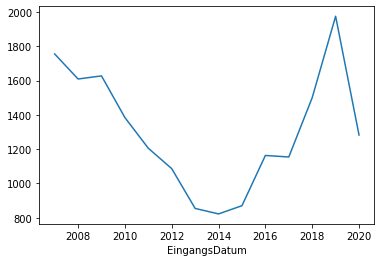

In [67]:
df['EingangsDatum'].groupby(df['EingangsDatum'].dt.year).size().plot()

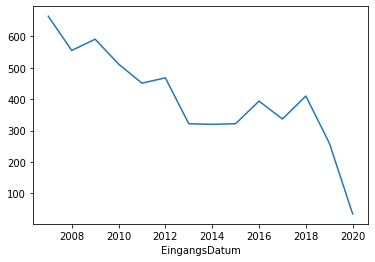

In [68]:
df.query('visa_erteilt').groupby(df['EingangsDatum'].dt.year).size().plot()

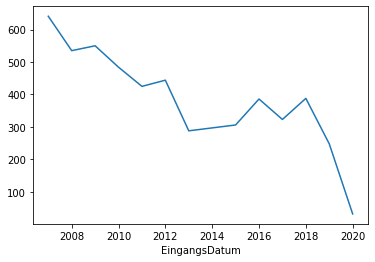

In [69]:
df.query('visa_mit_vergleich').groupby(df['EingangsDatum'].dt.year).size().plot()

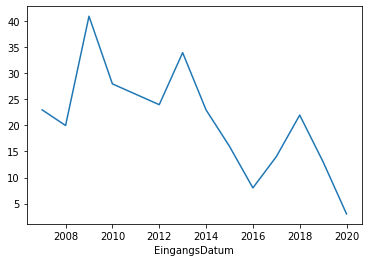

In [70]:
df.query('visa_ohne_vergleich').groupby(df['EingangsDatum'].dt.year).size().plot()

In [71]:
# (
#     alt.Chart(df.query('visa_erteilt'))
#     .mark_bar(
#         opacity=0.3,
#         interpolate='step'
#     ).encode(
#         alt.X('year(EingangsDatum):T', bin=True),
#         alt.Y('count():Q'),
#         alt.Color('visa_mit_vergleich')
#     )
# )

## Nach Ländern

In [72]:
df.query('visa_mit_vergleich')['country_name'].value_counts()[:50]

Turkey                               1094
Kosovo                                402
Syrian Arab Republic                  354
Viet Nam                              328
Morocco                               251
Pakistan                              205
Serbia                                192
India                                 172
Iraq                                  158
Ukraine                               141
North Macedonia                       122
Afghanistan                           117
Russian Federation                    108
Tunisia                               108
Iran, Islamic Republic of              88
Ghana                                  88
Bosnia and Herzegovina                 87
Nigeria                                86
Eritrea                                86
Lebanon                                84
Cameroon                               76
Egypt                                  67
Somalia                                55
Ethiopia                          

In [73]:
df.query('visa_ohne_vergleich')['country_name'].value_counts()[:50]

Turkey                               47
Syrian Arab Republic                 23
India                                22
Kosovo                               17
Viet Nam                             14
Iraq                                 13
Pakistan                             13
Morocco                              12
Serbia                                9
Afghanistan                           8
Nigeria                               8
Algeria                               8
Tunisia                               8
Bosnia and Herzegovina                7
Ghana                                 6
Russian Federation                    6
Kazakhstan                            5
Ukraine                               5
Cameroon                              4
Somalia                               4
North Macedonia                       4
Egypt                                 4
Philippines                           4
Lebanon                               4
Thailand                              3


## Klage zurückgezogen

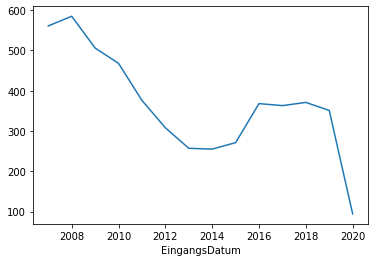

In [74]:
df.query('verfahrensausgang == "C"').groupby(df['EingangsDatum'].dt.year).size().plot()

## Visum erteilt, aber keine Kosten für's AA?

In [75]:
no_cost_aa = df.query('visa_erteilt and kosten_aa == 0')
no_cost_aa['verfahrensausgang'].value_counts()

D    4262
G     395
F      51
Name: verfahrensausgang, dtype: int64

In [76]:
no_cost_aa['Grund'].value_counts()

FZ-E      3246
FZ-K       724
FZ-E/K     500
FZ-F       238
Name: Grund, dtype: int64

## Visa erteilt ohne Vergleich

In [77]:
df_visa_ohne_vergleich = df.query('visa_erteilt and visa_ohne_vergleich')
df_visa_ohne_vergleich.head()

,LFD_NR,VG AZ,EingangsDatum,country,Vertretung,Grund,_Zusatz,Statistik,Statistk vom,Gz_OVG,Ausgang OVG,Datum OVG_,Gz PKH Beschwerde,Ausgang PKH,Datum PKH_,...,verfahrensausgang_ovg,verfahrensausgang_bverwg,highest_instance,kosten_aa_vg,kosten_aa_ovg,kosten_aa_bverwg,verfahrensausgang,kosten_aa,verfahrensausgang_datum,duration,verfahrensausgang_previously_f,familie,visa_erteilt,visa_mit_vergleich,visa_ohne_vergleich
94,25464,VG 35 V 3.07,2007-01-15,AFG,NaN,FZ-E,NaN,F,2007-10-29,NaN,NaN,NaT,NaN,NaN,NaT,...,NaN,NaN,vg,1.0,NaN,NaN,F,1.0,2007-10-29,287.0,True,True,True,False,True
243,25613,VG 7 V 21.07,2007-01-30,TUR,NaN,FZ-K,NaN,F,2008-04-10,NaN,NaN,NaT,NaN,NaN,NaT,...,NaN,NaN,vg,1.0,NaN,NaN,F,1.0,2008-04-10,436.0,True,True,True,False,True
281,25651,VG 14 V 1.07,2007-02-08,GHA,NaN,FZ-K,NaN,F,2008-01-09,NaN,NaN,NaT,NaN,NaN,NaT,...,NaN,NaN,vg,1.0,NaN,NaN,F,1.0,2008-01-09,335.0,True,True,True,False,True
303,25673,VG 15 V 5.07,2007-02-08,TUR,NaN,FZ-E,NaN,F,2007-07-26,NaN,NaN,NaT,NaN,NaN,NaT,...,NaN,NaN,vg,1.0,NaN,NaN,F,1.0,2007-07-26,168.0,True,True,True,False,True
402,25772,VG 26 V 10.07,2007-02-23,SRB,NaN,FZ-E,NaN,F,2007-11-23,NaN,NaN,NaT,NaN,NaN,NaT,...,NaN,NaN,vg,1.0,NaN,NaN,F,1.0,2007-11-23,273.0,True,True,True,False,True


In [78]:
df_visa_ohne_vergleich['kosten_aa'].value_counts(normalize=True)

1.0    0.776271
0.0    0.172881
0.5    0.050847
Name: kosten_aa, dtype: float64

In [79]:
df_final['verfahrensausgang'].value_counts()

C    5134
D    4358
A    3919
G     989
J     886
F     295
E      31
K      26
I       8
B       7
Name: verfahrensausgang, dtype: int64

In [80]:
df_final[df_final['verfahrensausgang'].isin(['B','I','K','E','J'])]['visa_erteilt'].value_counts()

False    958
Name: visa_erteilt, dtype: int64

In [81]:
df_final[~df_final['visa_erteilt']]['kosten_aa'].value_counts()

0.0    9717
1.0     206
0.5      88
Name: kosten_aa, dtype: int64

## Export cleaned CSV

In [82]:
df.to_csv('cleaned.csv', index=False)